In [1]:
from typing import Literal, TypedDict
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command


class State(TypedDict):
    question: str
    difficulty: str
    answer: str

class DifficultyResponse(BaseModel):
    difficulty: Literal["easy", "medium", "hard"]


llm = init_chat_model("openai:gpt-4o-mini")
easy_llm = init_chat_model("openai:gpt-3.5-turbo")
medium_llm = init_chat_model("openai:gpt-4o-mini")
hard_llm = init_chat_model("openai:gpt-5-mini")

In [2]:
def assess_difficulty(
    state: State,
) -> Literal["dumb_node", "average_node", "smart_node"]:
    user_question = state["question"]

    structured_llm = llm.with_structured_output(DifficultyResponse)

    prompt = f"""사용자의 질문을 보고 답변의 난이도를 출력하세요.
    easy: 답변하기 쉬운 질문일 때
    medium: 답변하기 약간 어려운 질문일 때
    hard: 답변하기 어려운 질문일 떄
    사용자의 질문:{user_question}
    """

    response = structured_llm.invoke(prompt)

    if response.difficulty == "easy":
        goto = "dumb_node"
    elif response.difficulty == "medium":
        goto = "average_node"
    elif response.difficulty == "hard":
        goto = "smart_node"

    return Command(
        goto=goto,
        update={
            "difficulty": response.difficulty,
        },
    )


def dumb_node(state: State):
    response = easy_llm.invoke(state["question"])

    return {
        "answer": response.content
    }

def average_node(state: State):
    response = medium_llm.invoke(state["question"])

    return {"answer": response.content}

def smart_node(state: State):
    response = hard_llm.invoke(state["question"])

    return {"answer": response.content}

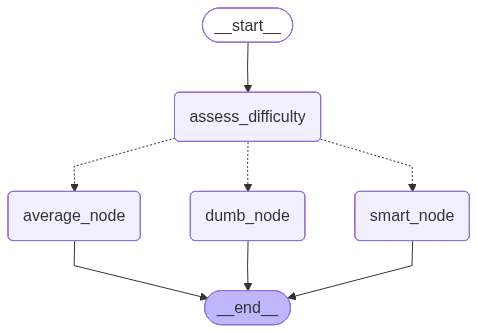

In [5]:
graph_builder = StateGraph(State)

graph_builder.add_node(
    "assess_difficulty",
    assess_difficulty,
    destinations=["dumb_node", "average_node", "smart_node"],
)
graph_builder.add_node("dumb_node", dumb_node)
graph_builder.add_node("average_node", average_node)
graph_builder.add_node("smart_node", smart_node)

graph_builder.add_edge(START, "assess_difficulty")
graph_builder.add_edge("dumb_node", END)
graph_builder.add_edge("average_node", END)
graph_builder.add_edge("smart_node", END)

graph = graph_builder.compile()

graph

In [7]:
graph.invoke(
    {
        "question": "카발라가뭐야? 종교적인 의미에서"
    }
)

{'question': '카발라가뭐야? 종교적인 의미에서',
 'difficulty': 'medium',
 'answer': "카발라(Kabbalah)는 주로 유대교의 신비주의 전통으로, 신과 우주의 본질, 인간의 존재 및 영혼의 여정에 대한 깊은 이해를 추구하는 철학적이고 종교적인 체계입니다. 카발라는 '받음' 또는 '전달'이라는 의미를 가진 히브리어에서 유래했으며, 고대 유대교의 경전과 신비주의적 요소를 기반으로 합니다.\n\n카발라는 다음과 같은 주요 개념을 포함합니다:\n\n1. **세피로트(Sefirot)**: 카발라에서는 신의 속성을 나타내는 10개의 세피로트를 중심으로 한 나무의 형태로 표현됩니다. 이 세피로트는 신과 인류가 연결되는 경로를 나타냅니다.\n\n2. **모네스티(Monistic) 및 다신론(Polytheistic)**: 카발라에서는 궁극적인 실재인 '인피니트'(Ein Sof)를 중심으로 모든 것이 연결되어 있다고 믿고, 이는 신과 인간, 우주 간의 깊은 상호작용을 설명합니다.\n\n3. **창조와 신의 의도**: 카발라는 신이 세상을 창조한 방법에 대한 교리를 탐구하며, 이를 통해 성경의 깊은 의미와 인간의 존재 이유를 파악하려고 합니다.\n\n4. **영적 여정**: 인간의 영혼은 신과의 연합을 통해 완전함을 추구하는 과정으로 여겨지며, 카발라의 실천은 이러한 영적 진화를 도와줍니다.\n\n카발라는 역사적으로 비밀스럽고 엘리트적인 전통이었지만, 현대에 들어서는 더욱 많은 사람들에게 알려지고 연구되고 있습니다. 왜냐하면 카발라의 가르침은 개인의 정신적 성장뿐만 아니라, 더 나아가 인류 전체에 대한 통찰을 제공하기 때문입니다."}